In [5]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import time
import torch
from pytorchtools import EarlyStopping
import math
import numpy as np

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SWong7923\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
reviews = pd.read_csv('\\Users\\SWong7923\\PycharmProjects\\pythonProject2\\archive\\Reviews.csv')

In [8]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [9]:
reviews.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
reviews.shape

(568454, 10)

In [11]:
reviews.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [12]:
# reviews['Summary'].replace('',np.nan,inplace=True)
reviews.dropna(subset=['Summary', 'Text'],inplace=True)

In [13]:
reviews.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    0
Text                       0
dtype: int64

In [14]:
reviews.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [15]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck','fuk', 'wtf','fucck','f cking'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$'
                                                           '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s'
        ],

    ' asshole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'ass hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h','beetch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' transgender':
        [
            'transgender','trans gender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k','diick '
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bullshit ':
        [
            'bullsh\*t', 'bull\$hit','bs'
        ],

    ' homosexual':
        [
            'homo sexual','homosex'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots', 'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t'
        ],

    ' shithole ':
        [
            'shythole','shit hole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumbass':
        [
            'dumb ass', 'dubass'
        ],

    ' asshead':
        [
            'butthead', 'ass head'
        ],

    ' sex ':
        [
            's3x', 'sexuality',
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' motherfucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker', 'mother fucker'
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    " White's " : 'white'
}

In [16]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'<br >', '', text)
    text = re.sub(r'\'', ' ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [17]:
clean_summaries = []
for summary in reviews.Summary:
    if not isinstance(summary, str):
        print(summary)
        continue
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print("Summaries are complete.")

clean_texts = []
for text in reviews.Text:
    clean_texts.append(clean_text(text))
print("Texts are complete.")

Summaries are complete.
Texts are complete.


In [18]:
# Inspect the cleaned summaries and texts to ensure they have been cleaned well
for i in range(15,20):
    print("Clean Review #",i+1)
    print("Summary: ",clean_summaries[i])
    print("Content: ",clean_texts[i])
    print()

Clean Review # 16
Summary:  lots of twizzlers  just what you expect 
Content:  daughter loves twizzlers shipment six pounds really hit spot exactly would expect six packages strawberry twizzlers

Clean Review # 17
Summary:  poor taste
Content:  love eating good watching tv looking movies sweet like transfer zip lock baggie stay fresh take time eating

Clean Review # 18
Summary:  love it 
Content:  satisfied twizzler purchase shared others enjoyed definitely ordering

Clean Review # 19
Summary:  great sweet candy 
Content:  twizzlers strawberry childhood favorite candy made lancaster pennsylvania candies inc one oldest confectionery firms united states subsidiary hershey company company established 1845 young smylie also make apple licorice twists green color blue raspberry licorice twists like all<br ><br >i keep dry cool place recommended put fridge according guinness book records longest licorice twist ever made measured 1 200 feet 370 weighted 100 pounds 45 kg made candies inc recor

In [19]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [20]:
word_counts = {}

count_words(word_counts, clean_summaries)
count_words(word_counts, clean_texts)
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 132887


In [21]:
embeddings_index = {}
with open('\\Users\\SWong7923\\PycharmProjects\\pythonProject2\\archive\\numberbatch-en.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding
print('Word embeddings:', len(embeddings_index))

Word embeddings: 417195


In [22]:
# Find the number of words that are missing from CN, and are used more than our threshold.
missing_words = 0
threshold = 20

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from CN:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from CN: 3870
Percent of words that are missing from vocabulary: 2.91%


In [23]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>","<EOS>","<GO>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(vocab_to_int))
print("Percent of words we will use: {}%".format(usage_ratio))

Total number of unique words: 132887
Number of words we will use: 59595
Percent of words we will use: 44.85%


In [24]:
# Need to use 300 for embedding dimensions to match CN's vectors.
embedding_dim = 300
nb_words = len(vocab_to_int)

# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in CN, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

59595


In [25]:
def convert_to_ints(text, word_count, unk_count):
    '''Convert words in text to an integer(the index of words in vocabulary).
       If word is not in vocab_to_int, use UNK's integer.
       Total the number of words and UNKs.
       Add EOS token to the end of texts'''
    ints = []
    for sentence in text:
        sentence_ints = [vocab_to_int["<GO>"]]
        for word in sentence.split():
            word_count += 1
            if word in vocab_to_int:
                sentence_ints.append(vocab_to_int[word])
            else:
                sentence_ints.append(vocab_to_int["<UNK>"])
                unk_count += 1
       
        sentence_ints.append(vocab_to_int["<EOS>"])
        ints.append(sentence_ints)
    return ints, word_count, unk_count

In [26]:
# Apply convert_to_ints to clean_summaries and clean_texts
word_count = 0
unk_count = 0

int_summaries, word_count, unk_count = convert_to_ints(clean_summaries, word_count, unk_count)
int_texts, word_count, unk_count = convert_to_ints(clean_texts, word_count, unk_count)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 25680389
Total number of UNKs in headlines: 192248
Percent of words that are UNK: 0.75%


In [27]:
def create_lengths(text):
    '''Create a data frame of the sentence lengths from a text'''
    lengths = []
    for sentence in text:
        lengths.append(len(sentence))
    return pd.DataFrame(lengths, columns=['counts'])

In [28]:
lengths_summaries = create_lengths(int_summaries)
lengths_texts = create_lengths(int_texts)

print("Summaries:")
print(lengths_summaries.describe())
print()
print("Texts:")
print(lengths_texts.describe())

Summaries:
              counts
count  568427.000000
mean        6.181613
std         2.657912
min         2.000000
25%         4.000000
50%         6.000000
75%         7.000000
max        50.000000

Texts:
              counts
count  568427.000000
mean       42.996376
std        42.520534
min         2.000000
25%        19.000000
50%        30.000000
75%        51.000000
max      2086.000000


In [29]:
# Inspect the length of texts
print(np.percentile(lengths_texts.counts, 90))
print(np.percentile(lengths_texts.counts, 95))
print(np.percentile(lengths_texts.counts, 99))

85.0
116.0
208.0


In [30]:
# Inspect the length of summaries
print(np.percentile(lengths_summaries.counts, 90))
print(np.percentile(lengths_summaries.counts, 95))
print(np.percentile(lengths_summaries.counts, 99))

10.0
11.0
15.0


In [31]:
def unk_counter(sentence):
    '''Counts the number of time UNK appears in a sentence.'''
    unk_count = 0
    for word in sentence:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
    return unk_count

In [32]:
# takes a long time  , this is normal

# Sort the summaries and texts by the length of the texts, shortest to longest
# Limit the length of summaries and texts based on the min and max ranges.
# Remove reviews that include too many UNKs

sorted_summaries = []
sorted_texts = []
max_text_length = 84
max_summary_length = 13
min_length = 2
unk_text_limit = 1
unk_summary_limit = 0

for length in range(min(lengths_texts.counts), max_text_length): 
    for count, words in enumerate(int_summaries):
        if (len(int_summaries[count]) >= min_length and
            len(int_summaries[count]) <= max_summary_length and
            len(int_texts[count]) >= min_length and
            unk_counter(int_summaries[count]) <= unk_summary_limit and
            unk_counter(int_texts[count]) <= unk_text_limit and
            length == len(int_texts[count])
           ):
            sorted_summaries.append(int_summaries[count])
            sorted_texts.append(int_texts[count])
        
# Compare lengths to ensure they match
print(len(sorted_summaries))
print(len(sorted_texts))

472193
472193


In [33]:
#sorted_texts[-100:-1]

In [34]:
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import torch.nn as nn
import matplotlib.pyplot as plt
import random 

In [35]:
# Subset the data for training
start = 200000
end = start + 300000
sorted_summaries_short = sorted_summaries[start:end]
sorted_texts_short = sorted_texts[start:end]
print("The shortest text length:", len(sorted_texts_short[0]))
print("The longest text length:",len(sorted_texts_short[-1]))

The shortest text length: 24
The longest text length: 83


In [36]:
" ".join([int_to_vocab[i] for i in sorted_texts_short[2]])

'<GO> usually buy go go brown rice convenience time cook use rice noticeable change pleasing smell taste hybrid rice love high quality rice <EOS>'

In [37]:
train_size = int(len(sorted_texts_short) * 0.9)
val_size = len(sorted_texts_short) - train_size
zipped = list(zip(sorted_texts_short, sorted_summaries_short))
train_dataset, val_dataset = torch.utils.data.random_split(zipped, [train_size,val_size])
text_train, summ_train = zip(*train_dataset)
text_val, summ_val = zip(*val_dataset)


In [38]:
" ".join([int_to_vocab[i] for i in summ_train[3]])

'<GO> it is not too good to be true <EOS>'

In [39]:
" ".join([int_to_vocab[i] for i in text_train[3]])

'<GO> greatest low fat organic snack ever tasted taste like pumpernickel bread holidays love haves 1 5 grams fat 14 pretzels hearty snack say enough great things snack <EOS>'

In [40]:
[len(x)for x in text_train[:10]]

[44, 76, 46, 29, 24, 79, 24, 43, 75, 41]

In [41]:
def len_argsort(seq):
    return sorted(range(len(seq)), key=lambda x: len(seq[x]))

In [42]:
sorted_index = len_argsort(text_train)
text_train = [text_train[i] for i in sorted_index]
summ_train = [summ_train[i] for i in sorted_index]

In [43]:
[len(x)for x in text_train[-2:-1]] # 24 - 83

[83]

In [44]:
k = 2
print(" ".join([int_to_vocab[i] for i in text_train[k]]))
print(" ".join([int_to_vocab[i] for i in summ_train[k]]))

<GO> bought elderly cat health problems needs gain weight coincidentally new kitten well 4 cats love food none like wet food forever food <EOS>
<GO> approved of by all my felines <EOS>


In [45]:
# 按索引划分batch，返回的每个batch中存的是index
def get_minibatches(n, minibatch_size, shuffle=True):
    idx_list = np.arange(0, n, minibatch_size)
    if shuffle:
        np.random.shuffle(idx_list)
    minibatches = []
    for idx in idx_list:
        minibatches.append(np.arange(idx, min(idx+minibatch_size, n)))
    return minibatches      # 这个会返回多批连着的bath_size个索引  
#get_minibatches(len(train_en), 32)

# 这个函数是在做数据预处理， 由于每个句子都不是一样长， 所以通过这个函数就可以把句子进行补齐， 不够长的在句子后面添加0
def prepare_data(seqs):
    lengths = [len(seq) for seq in seqs]    # 得到每个句子的长度
    n_samples = len(seqs)       # 得到一共有多少个句子
    max_len = np.max(lengths)              # 找出最大的句子长度
    
    x = np.zeros((n_samples, max_len)).astype('int32')    # 按照最大句子长度生成全0矩阵
    x_lengths = np.array(lengths).astype('int32')
    for idx, seq in enumerate(seqs):        # 把有句子的位置填充进去
        x[idx, :lengths[idx]] = seq
    return x, x_lengths      # x_mask

def gen_examples(en_sentences, cn_sentences, batch_size):
    minibatches = get_minibatches(len(en_sentences), batch_size)   # 得到batch个索引
    all_ex = []
    for minibatch in minibatches:   # 每批数据的索引
        mb_en_sentences = [en_sentences[t] for t in minibatch]   # 取数据
        mb_cn_sentences = [cn_sentences[t] for t in minibatch]  # 取数据
        mb_x, mb_x_len = prepare_data(mb_en_sentences) # 填充成一样的长度， 但是要记录一下句子的真实长度， 这个在后面输入网络的时候得用
        mb_y, mb_y_len = prepare_data(mb_cn_sentences)
        all_ex.append((mb_x, mb_x_len, mb_y, mb_y_len))
    return all_ex

batch_size = 64
train_data = gen_examples(text_train, summ_train, batch_size)   # 产生训练集
random.shuffle(train_data)
dev_data = gen_examples(text_val, summ_val, batch_size)   # 产生验证集


In [46]:
print(train_data[1][0].shape, train_data[1][1].shape, train_data[1][2].shape, train_data[1][3].shape)  

(64, 46) (64,) (64, 11) (64,)


In [47]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, enc_hidden_size, dec_hidden_size, dropout=0.2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, enc_hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(enc_hidden_size * 2, dec_hidden_size)

    def forward(self, x, lengths):
        sorted_len, sorted_idx = lengths.sort(0, descending=True)
        x_sorted = x[sorted_idx.long()]
        embedded = self.dropout(self.embed(x_sorted))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, sorted_len.long().cpu().data.numpy(), batch_first=True)
        packed_out, hid = self.rnn(packed_embedded)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        _, original_idx = sorted_idx.sort(0, descending=False)
        out = out[original_idx.long()].contiguous() # [batch_size, seq_len, num_directions=2 * enc_hidden_size]
        hid = hid[:, original_idx.long()].contiguous() # [num_layers=1 * num_directions=2, batch_size, enc_hidden_size]
        
        # hid[m] [batch_size, enc_hidden_size]
        hid = torch.cat([hid[-2], hid[-1]], dim=1) # [batch_size, enc_hidden_size*2]
        hid = torch.tanh(self.fc(hid)).unsqueeze(0) # [1,batch_size,dec_hidden_size]

        return out, hid

In [48]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super().__init__()
        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size
        self.linear_in = nn.Linear(enc_hidden_size*2, dec_hidden_size, bias=False)
        self.linear_out = nn.Linear(enc_hidden_size*2 + dec_hidden_size, dec_hidden_size)
        
    def forward(self, output, context, mask):
        # output: [batch_size, output_len, dec_hidden_size]
        # context: [batch_size, context_len, 2*enc_hidden_size]
    
        batch_size = output.size(0)
        output_len = output.size(1)
        input_len = context.size(1)
        
        context_in = self.linear_in(context.view(batch_size*input_len, -1)).view(                
            batch_size, input_len, -1) # batch_size, context_len, dec_hidden_size
        
        # context_in.transpose(1,2): batch_size, dec_hidden_size, context_len 
        # output: batch_size, output_len, dec_hidden_size
        attn = torch.bmm(output, context_in.transpose(1,2))  # batch_size, output_len, context_len

        # mask必须是一个 ByteTensor 而且shape必须和 attn 一样 并且元素只能是 0或者1
        # tensor.data.masked_fill(mask,value):将 mask中为1的 元素所在的索引，在tensor中相同的的索引处替换为 value
        # 将不是单词的位置设成很小的数,使softmax不受非单词的元素影响
        attn.data.masked_fill(mask, -1e6)

        attn = F.softmax(attn, dim=2)  # batch_size, output_len, context_len

        context = torch.bmm(attn, context) 
        # batch_size, output_len, 2*enc_hidden_size
        
        output = torch.cat((context, output), dim=2) # batch_size, output_len, enc_hidden_size*2 + dec_hidden_size

        output = output.view(batch_size*output_len, -1)
        output = torch.tanh(self.linear_out(output))
        output = output.view(batch_size, output_len, -1) # batch_size, output_len, dec_hidden_size
        return output, attn

In [49]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, enc_hidden_size, dec_hidden_size, dropout=0.2):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        self.rnn = nn.GRU(embed_size, dec_hidden_size, batch_first=True)
        self.out = nn.Linear(dec_hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def create_mask(self, y_len, x_len):
        max_y_len = y_len.max()
        max_x_len = x_len.max()
        x_mask = torch.arange(max_x_len, device=x_len.device)[None, :] < x_len[:, None] # [batch_size,max_x_len]
        y_mask = torch.arange(max_y_len, device=x_len.device)[None, :] < y_len[:, None] # [batch_size,max_y_len]
        # 以1个batch的1句话为例(英文共n个字),取其中一个中文字(矩阵的某行),英文前n个字(列)值为0,为0代表有效
        # ~代表bool变量取反
        mask = (~(y_mask[:, :, None] * x_mask[:, None, :])).byte() # [batch_size,max_y_len,max_x_len]
        return mask
    
    def forward(self, ctx, ctx_lengths, y, y_lengths, hid):
        sorted_len, sorted_idx = y_lengths.sort(0, descending=True)
        y_sorted = y[sorted_idx.long()] # [batch_size,y_len,vocab_size]
        hid = hid[:, sorted_idx.long()]
        
        y_sorted = self.dropout(self.embed(y_sorted)) # batch_size, 中文seq_length, embed_size

        packed_seq = nn.utils.rnn.pack_padded_sequence(y_sorted, sorted_len.long().cpu().data.numpy(), batch_first=True)
        out, hid = self.rnn(packed_seq, hid)
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True) # [batch_size,中文seq_len,dec_hidden_size]
        
        _, original_idx = sorted_idx.sort(0, descending=False)
        
        output_seq = unpacked[original_idx.long()].contiguous() # [batch_size,中文seq_len,dec_hidden_size]
        
        hid = hid[:, original_idx.long()].contiguous() # [1,batch_size,dec_hidden_size]

        mask = self.create_mask(y_lengths, ctx_lengths) # [batch_size,中文seq_len,英文seq_len]

        # output [batch_size, 中文seq_len, dec_hidden_size]
        # attn [batch_size,中文seq_len,英文seq_len]
        output, attn = self.attention(output_seq, ctx, mask)
        
        output = F.log_softmax(self.out(output), dim=-1) # batch_size, output_len, vocab_size
        
        return output, hid, attn

In [50]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x, x_lengths, y, y_lengths):
        encoder_out, hid = self.encoder(x, x_lengths)
        output, hid, attn = self.decoder(ctx=encoder_out, 
                    ctx_lengths=x_lengths,
                    y=y,
                    y_lengths=y_lengths,
                    hid=hid)
        return output
    
    def translate(self, x, x_lengths, y, max_length=100):
        encoder_out, hid = self.encoder(x, x_lengths)
        preds = []
        batch_size = x.shape[0]
        attns = []
        for i in range(max_length):
            output, hid, attn = self.decoder(ctx=encoder_out, 
                    ctx_lengths=x_lengths,
                    y=y,
                    y_lengths=torch.ones(batch_size).long().to(y.device),
                    hid=hid)
            y = output.max(2)[1].view(batch_size, 1)
            preds.append(y)
            attns.append(attn)
        return torch.cat(preds, dim=1)

In [51]:
# masked cross entropy loss
class LanguageModelCriterion(nn.Module):
    def __init__(self):
        super(LanguageModelCriterion, self).__init__()
    
    def forward(self, input, target, mask):
        # input: [batch_size, seq_len, vocab_size]    每个单词的可能性
        input = input.contiguous().view(-1, input.size(2))   # [batch_size*seq_len-1, vocab_size] 将input的batch_size和seq_len合并，再计算loss
        target = target.contiguous().view(-1, 1)    #  [batch_size*seq_len-1, 1] # target里dim=1存的是正确summary 的index
        
        mask = mask.contiguous().view(-1, 1)   # [batch_size*seq_len-1, 1]
        output = -input.gather(1, target) * mask # 在每个vocab_size维度取正确单词的索引， 但是里面有很多是填充进去的， 所以mask去掉这些填充的， 
        output = torch.sum(output) / torch.sum(mask)
        
        return output  # [batch_size*seq_len-1, 1]

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dropout = 0.2
hidden_size = 100
embed_size = 100
encoder = Encoder(vocab_size=len(word_embedding_matrix), embed_size=embed_size, enc_hidden_size=hidden_size, dec_hidden_size=hidden_size,)
decoder = Decoder(vocab_size=len(word_embedding_matrix), embed_size=embed_size, enc_hidden_size=hidden_size, dec_hidden_size=hidden_size,)

model = Seq2Seq(encoder, decoder)
model = model.to(device)
loss_fn = LanguageModelCriterion().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [57]:
# 定义训练和验证函数
train_losses = []
val_losses = []
#Please see the link below to learn about early stopping
#https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd 
min_val_loss = 100
early_stop = False
def evaluate(model, data):
    model.eval()
    total_num_words = total_loss = 0.
    with torch.no_grad():
        for it, (mb_x, mb_x_len, mb_y, mb_y_len) in enumerate(data):
            mb_x = torch.from_numpy(mb_x).to(device).long()    # 这个是一个batch的英文句子 大小是[batch_size, seq_len]
            mb_x_len = torch.from_numpy(mb_x_len).to(device).long()    # 每个句子的长度
            mb_input = torch.from_numpy(mb_y[:, :-1]).to(device).long()  # decoder的输入，训练的时候是整个summary（带<GO>）
            mb_output = torch.from_numpy(mb_y[:, 1:]).to(device).long()   # 解码器那边的输出  [batch_size, seq_len-1]去掉<GO>
            mb_y_len = torch.from_numpy(mb_y_len-1).to(device).long()  # 这个减去1， 去掉初始符号 [batch_size, seq_len-1]
            mb_y_len[mb_y_len<=0] =  1   # 以防出错，防止trainset里面的summary长度被记为0（实际上不可能）
            
            mb_pred = model(mb_x, mb_x_len, mb_input, mb_y_len)
            
            mb_out_mask = torch.arange(mb_y_len.max().item(), device=device)[None, :] < mb_y_len[:, None]  
            # [batch_size,最长句子的长度], 上面是bool类型， 下面是float类型， 只计算每个句子的有效部分， 填充的那部分去掉
            mb_out_mask = mb_out_mask.float()  # [batch_size, seq_len-1]  因为mb_y_len.max()就是seq_len-1
            
            loss = loss_fn(mb_pred, mb_output, mb_out_mask)
            
            num_words = torch.sum(mb_y_len).item()
            total_loss += loss.item() * num_words
            total_num_words += num_words
            
    #print('Validation loss', total_loss / total_num_words)
    val_loss = total_loss / total_num_words;
    val_losses.append(val_loss)
    return val_loss

def train(model, data, num_epochs, patience):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(1, num_epochs+1):
        model.train()
        total_num_words = total_loss = 0.
        for it, (mb_x, mb_x_len, mb_y, mb_y_len) in enumerate(data):
            mb_x = torch.from_numpy(mb_x).to(device).long()
            mb_x_len = torch.from_numpy(mb_x_len).to(device).long()
            mb_input = torch.from_numpy(mb_y[:, :-1]).to(device).long()
            mb_output = torch.from_numpy(mb_y[:, 1:]).to(device).long()
            mb_y_len = torch.from_numpy(mb_y_len-1).to(device).long()
            mb_y_len[mb_y_len<=0] = 1
            
            mb_pred = model(mb_x, mb_x_len, mb_input, mb_y_len)
            
            mb_out_mask = torch.arange(mb_y_len.max().item(), device=device)[None, :] < mb_y_len[:, None]
            mb_out_mask = mb_out_mask.float()
            
            loss = loss_fn(mb_pred, mb_output, mb_out_mask)
            
            num_words = torch.sum(mb_y_len).item()
            total_loss += loss.item() * num_words
            total_num_words += num_words
            
            # 更新
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)     # 防止梯度爆炸
            optimizer.step()
            
            #if it % 100 == 0:
            #   print('Epoch', epoch, 'iteration', it, 'loss', loss.item())
       
        #print('Epoch', epoch, 'Training loss', total_loss / total_num_words)
        trainingloss = total_loss / total_num_words;
        train_losses.append(trainingloss)
        #if epoch % 5 == 0:
        val_loss=evaluate(model, dev_data)
        
        epoch_len = len(str(num_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                     f'train_loss: {trainingloss:.5f} ' +
                     f'valid_loss: {val_loss:.5f}')
        
        print(print_msg)
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        model.load_state_dict(torch.load('checkpoint.pt'))
            
train(model, train_data, num_epochs=50, patience=5)

[ 1/50] train_loss: 4.13072 valid_loss: 3.97102
Validation loss decreased (inf --> 3.971024).  Saving model ...
[ 2/50] train_loss: 3.81447 valid_loss: 3.78429
Validation loss decreased (3.971024 --> 3.784292).  Saving model ...
[ 3/50] train_loss: 3.61617 valid_loss: 3.66755
Validation loss decreased (3.784292 --> 3.667548).  Saving model ...
[ 4/50] train_loss: 3.47153 valid_loss: 3.58305
Validation loss decreased (3.667548 --> 3.583047).  Saving model ...
[ 5/50] train_loss: 3.35908 valid_loss: 3.52305
Validation loss decreased (3.583047 --> 3.523053).  Saving model ...
[ 6/50] train_loss: 3.26630 valid_loss: 3.47380
Validation loss decreased (3.523053 --> 3.473801).  Saving model ...
[ 7/50] train_loss: 3.18794 valid_loss: 3.43626
Validation loss decreased (3.473801 --> 3.436259).  Saving model ...
[ 8/50] train_loss: 3.12061 valid_loss: 3.40811
Validation loss decreased (3.436259 --> 3.408108).  Saving model ...
[ 9/50] train_loss: 3.06018 valid_loss: 3.37973
Validation loss decre

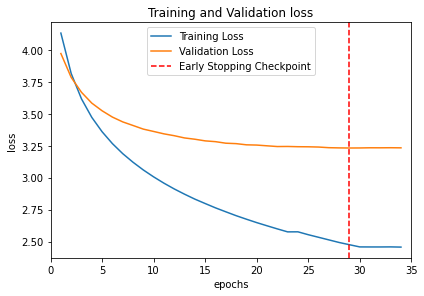

In [58]:
# epoch = range(num_epochs)
# fig, ax = plt.subplots()
# plt.plot(epoch, train_losses, 'g', label='Training loss')
# plt.plot(epoch, val_losses, 'b', label='Validation loss')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# ax.set_xticks(epoch)
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

 # visualize the loss as the network trained
fig = plt.figure()
plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
plt.plot(range(1,len(val_losses)+1),val_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = val_losses.index(min(val_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim(1, 5) # consistent scale
plt.xlim(0, len(train_losses)+1) # consistent scale
#plt.grid(True)
plt.legend()
plt.tight_layout()
plt.title('Training and Validation loss')
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [62]:
def translate_dev(i):
    text = " ".join([int_to_vocab[w] for w in text_val[i]])
    print(text)
    summary = " ".join([int_to_vocab[w] for w in summ_val[i]])
    print(summary)

    mb_x = torch.from_numpy(np.array(text_val[i]).reshape(1,-1)).long().to(device)
    mb_x_len = torch.from_numpy(np.array([len(text_val[i])])).long().to(device)
    # mb_y = torch.from_numpy(summ_val[i].reshape(1,-1)).long().to(device)
    # mb_y_len = torch.from_numpy([len(summ_val[i])]).long().to(device)
    bos = torch.Tensor([[vocab_to_int["<GO>"]]]).long().to(device)
    # 翻译时decoder的输入序列bos： [<GO>的index] 
    translation = model.translate(mb_x,mb_x_len, bos)
    translation = [int_to_vocab[i] for i in translation.data.cpu().numpy().reshape(-1)]
    trans = []
    for word in translation:
        if word !="<EOS>":
            trans.append(word)
        else:
            break
    print(" ".join(trans))
    

In [63]:
for i in range(110,130):
    translate_dev(i)
    print()

<GO> get large bags 3 dollars walmart 3 50 stop shop selling 5 dollars bag um thanks love though addicted buy target walmart youe grocery store though <EOS>
<GO> bad deal <EOS>
love these

<GO> ordered product parents send denmark cost lot shipping fees upon arrival left disappointed <br ><br >the product trolli brand gummy worms rather gift shop type knock furthermore trolli sold store contain gluten celiac disease made obsolete <br ><br >in defense could old <UNK> brand worms used would old looked new taste consistency normal trolli worms <EOS>
<GO> not as advertised <EOS>
not as good as the original

<GO> babies sour albeit sour coating disappears quickly leaving sweet lemon drop first time put one mouth think put hair chest expecting sour taste never tasted something quite sour another reviewer stated candies great surprising others given watched guests spit across room expecting initial sour bite even surprisingly addictive get local japanese grocery much cheaper amazon offers eve

In [64]:
translate_dev(250)

<GO> dried blue berry little chewy taste great add special k morning talk great bm fact eat much well never mind dont east much without eating bunch cheese afterwards <EOS>
<GO> tastes great <EOS>
great for diabetics


In [ ]:
#torch.save(model.state_dict(), '\\Users\\SWong7923\\PycharmProjects\\pythonProject2\\model\\checkpoint.pt'

In [ ]:
model.load_state_dict(torch.load('\\Users\\SWong7923\\PycharmProjects\\pythonProject2\\checkpoint.pt'))